## ASTR 597A Homework 2
Eric Bellm

Due Jan 17, 2023

Your name: David
    
Your collaborators: Tobin, Jake, Tom

In [1]:
# Import general python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas
from astropy import units as u
from astropy.coordinates import SkyCoord

# Import the Rubin TAP service utilities
from lsst.rsp import get_tap_service, retrieve_query

### Setup

In [2]:
# create the TAP service client
service = get_tap_service()

In [3]:
# we will all use the same input coordinates and radii
center_coords = "62, -37"

As we saw in class, when we limit the number of rows returned from a query, we don't get the same set of rows returned each time.  It would be nice to choose a spatial region small enough to be able to load all of the records.  Let's count how many `isPrimary` objects there are at a fiducial radius:

In [4]:
radius_deg = 0.5

In [5]:
%%time
results = service.search("SELECT count(coord_ra)"
                         "FROM dp02_dc2_catalogs.Object "
                         "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "
                         f"CIRCLE('ICRS', {center_coords}, {radius_deg})) = 1 "
                         "AND detect_isPrimary = 1 ").to_table()

print(results['count'])

count 
------
400406
CPU times: user 10.1 ms, sys: 0 ns, total: 10.1 ms
Wall time: 4.77 s


Can we just "SELECT \*" and be on our way then?

## Exercise 1: Big Data


### Exercise 1a

How many `isPrimary` objects are in all of DP0.2?

In [6]:
results = service.search("SELECT count(coord_ra)"
                         "FROM dp02_dc2_catalogs.Object "
                         "WHERE detect_isPrimary = 1 ").to_table()
results

count
int64
161025835


There are 161025835 rows (i.e. > 161M objects) It took way too long to run (so I only ran it overnight before turning this notebook in) which also highlights the impracticality of doing SELECT *

### Exercise 1b

How much memory do you need to load one row of the Object table?

*Hint: use the dtypes of all the columns.*

In [7]:
%%time
# get one row
one_row = service.search("SELECT *"
                         "FROM dp02_dc2_catalogs.Object "
                         "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "
                         f"CIRCLE('ICRS', {center_coords}, {radius_deg})) = 1 "
                         "AND detect_isPrimary = 1 "
                         "LIMIT 1").to_table().to_pandas()

one_row

CPU times: user 242 ms, sys: 3.49 ms, total: 246 ms
Wall time: 2.5 s


,coord_dec,coord_ra,deblend_nChild,deblend_skipped,detect_fromBlend,detect_isDeblendedModelSource,detect_isDeblendedSource,detect_isIsolated,detect_isPatchInner,detect_isPrimary,...,z_pixelFlags_suspect,z_pixelFlags_suspectCenter,z_psfFlux,z_psfFlux_area,z_psfFlux_flag,z_psfFlux_flag_apCorr,z_psfFlux_flag_edge,z_psfFlux_flag_noGoodPixels,z_psfFluxErr,z_ra
0,-37.198251,62.02493,0,False,True,True,True,False,True,True,...,False,False,147.204939,66.720497,False,False,False,False,74.705087,62.02498


In [8]:
# get the number of rows with each dtype
fields = pd.DataFrame(one_row.dtypes.value_counts())

# get the sizes of each dtype and join with the fields df
sizes = pd.Series({x:x.itemsize for x in fields.index}, name='size')
fields = fields.join(sizes)

# multiply number of rows with each dtype with the size of the dtype and sum over all dtypes
size_of_row = sum(fields[0] * fields['size'])

print(f"The total size of one row is {size_of_row} bytes") 

The total size of one row is 4558 bytes


### Exercise 1c

What's the maximum number of full rows of the Object table can you load into a Medium instance on data.lsst.cloud?

In [9]:
size_of_disk = 6144 * 1024 ** 2 # bytes
print(f"We can load at most {size_of_disk / size_of_row:.0f} rows into memory on a medium instance")

We can load at most 1413438 rows into memory on a medium instance


This is only a few percent fo the total number of objects, so there's no way we can load all objects in DP0.2 (much less actual rubin data).

## Exercise 2: Scattered

When encountering a new dataset it is important to explore the data and understand its properties.  The tutorial notebook 02 will be a useful reference.  

(For the following exercises, use the `center_coords` and `radius_deg` defined above.)

### Exercise 2a: Star or galaxy?

What values can the `{band}_extendedness` entry take?  What fraction of the time do the values disagree between bands?  What if you only look at rows where none of the `{band}_extendedness_flag` are set?

In [10]:
# read the schema of the Object table
test = service.search("SELECT column_name, datatype, description, unit from TAP_SCHEMA.columns "
                         "WHERE table_name = 'dp02_dc2_catalogs.Object'")
tap_schema = test.to_table().to_pandas()

In [11]:
# find all columns with extendedness
tap_schema[tap_schema['column_name'].str.contains("_extendedness")]

,column_name,datatype,description,unit
75,g_extendedness,double,"Set to 1 for extended sources, 0 for point sou...",
76,g_extendedness_flag,boolean,Set to 1 for any fatal failure. Measured on g-...,
235,i_extendedness,double,"Set to 1 for extended sources, 0 for point sou...",
236,i_extendedness_flag,boolean,Set to 1 for any fatal failure. Measured on i-...,
399,r_extendedness,double,"Set to 1 for extended sources, 0 for point sou...",
400,r_extendedness_flag,boolean,Set to 1 for any fatal failure. Measured on r-...,
569,u_extendedness,double,"Set to 1 for extended sources, 0 for point sou...",
570,u_extendedness_flag,boolean,Set to 1 for any fatal failure. Measured on u-...,
733,y_extendedness,double,"Set to 1 for extended sources, 0 for point sou...",
734,y_extendedness_flag,boolean,Set to 1 for any fatal failure. Measured on y-...,


In [12]:
tap_schema[tap_schema['column_name'].str.contains("_extendedness")].iloc[0]['description']

'Set to 1 for extended sources, 0 for point sources. Measured on g-band.'

From the description, extendedness can take two values: 0 for point sources and 1 for extended sources. However, from the data later, we see that there are also nans.

In [13]:
# read the extendedness metrics for all objects in the given circle
ext_cols = ','.join([x for x in tap_schema['column_name'] if '_extendedness' in x])

In [14]:
# %%time
results = service.search(f"SELECT {ext_cols}, r_psfFlux_flag, "
                         "scisql_nanojanskyToAbMag(r_psfFlux) as r_psfMag, "
                         "scisql_nanojanskyToAbMagSigma(r_psfFlux, r_psfFluxErr) as r_psfMagErr "
                         "FROM dp02_dc2_catalogs.Object "
                         "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "
                         f"CIRCLE('ICRS', {center_coords}, {radius_deg})) = 1 "
                         "AND detect_isPrimary = 1 ").to_table()

In [15]:
df = results.to_pandas()
df['g_extendedness'].value_counts(dropna=False) # note the nans

1.0    304454
0.0     72097
NaN     23855
Name: g_extendedness, dtype: int64

In [16]:
# column names for extendedness and extendedness_flags
nonflag = [x for x in df.columns if  x[-4:] == 'ness']
flag = [x for x in df.columns if 'ness_flag' in x]

In [17]:
def find_pct(data, ignorena=False):
    """
    Finds the pct of rows with disagreement in extendedness values
    """
    if ignorena:
        nanlen = lambda x: sum(~np.isnan(x))
        nansums_by_row = data[nonflag].apply(np.nansum, axis=1)
        nanlens_by_row = data[nonflag].apply(nanlen, axis=1)
        breakdown = (nansums_by_row / nanlens_by_row).value_counts()
    if not ignorena:
        sums_by_row = data[nonflag].apply(np.sum, axis=1)
        lens_by_row = data[nonflag].apply(len, axis=1)
        breakdown = (sums_by_row / lens_by_row).value_counts()
    n_rows_agree = breakdown.loc[[0, 1]].sum() # When all bands are in agreement, the average value will be either 0 or 1
    return 1 - (n_rows_agree) / len(data)


In [18]:
percent_disagree = find_pct(df, ignorena=False)
print(f"Percent of rows disagreeing while treating nans as disagreements: {100 * percent_disagree:.1f}")

Percent of rows disagreeing while treating nans as disagreements: 53.2


In [19]:
percent_disagree = find_pct(df, ignorena=True)
print(f"Percent of rows disagreeing while ignoring bands with nan: {100 * percent_disagree:.1f}")

Percent of rows disagreeing while ignoring bands with nan: 30.1


In [20]:
# now subselect to only the rows where the flags are all set to zero (i.e. no failures)
all_false = df[df[flag].sum(axis=1) == 0]
percent_disagree = find_pct(all_false)
print(f"Percent of rows disagreeing with no failures: {100 * percent_disagree:.1f}")

Percent of rows disagreeing with no failures: 19.7


### Exercise 2b. Signal to Noise

Make a plot of PSF magnitude vs. magnitude error for r-band point sources in our region of interest.  Exclude sources with the PSF Flux general failure flag set.  Set the axes extents to a reasonable range and label your axes!

Hints:  Consult the [schema browser](https://dm.lsst.org/sdm_schemas/browser/dp02.html#Object) for column names.  Consider using [hexbin](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hexbin.html) instead of a scatter plot with `bins='log'`...

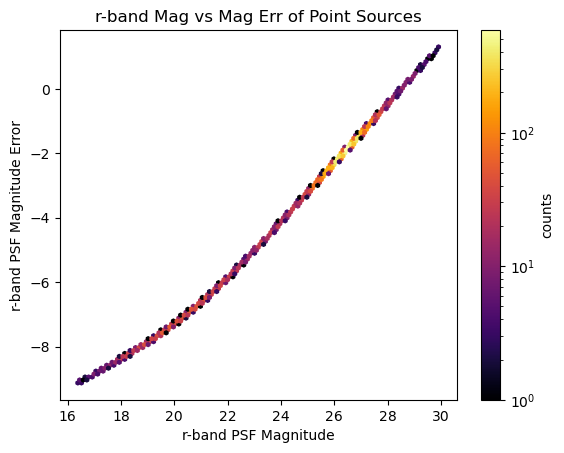

In [21]:
data = df[df['r_psfFlux_flag'] == False ] # Exclude sources with failure flag
data = data.query('r_psfMag < 30') # restrict data to <30 mag, which is already far fainter than the lsst r-band maglim
data = data[data[nonflag].sum(axis=1) == 0].dropna() # restrict to pt sources with extendedness == 0 in all 6 bands

# plot 2d histogram with hexbins
fig, ax = plt.subplots()
hb = ax.hexbin(data['r_psfMag'], np.log(data['r_psfMagErr']), bins='log', cmap='inferno')
ax.set_title("r-band Mag vs Mag Err of Point Sources")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')
ax.set_xlabel('r-band PSF Magnitude')
ax.set_ylabel('r-band PSF Magnitude Error')

plt.show()


## Exercise 3: Find a Transient or Variable

Using the `DIAObject` table, find an object with more than 1 magnitude of variability and plot its lightcurve.  The 07a and 07b tutorial notebooks may be helpful.

In [22]:
# Find an object with >50 detections and an amplitude of at least 1 mag in r band

test = service.search("SELECT ra, decl, diaObjectId, nDiaSources "
                      "FROM dp02_dc2_catalogs.DiaObject "
                      "WHERE nDiaSources > 50 AND "
                      "scisql_nanojanskyToAbMag(rPSFluxMin)"
                      f" - scisql_nanojanskyToAbMag(rPSFluxMax) > 1 ",
                      maxrec = 1)
                      # maxrec=100)
objId = test['diaObjectId'].data[0]

In [23]:
objId

1250355827013845367

In [24]:
# lightcurve of objId, which meets the criteria
data = service.search("SELECT ra, decl, diaObjectId, diaSourceId, "
                         "filterName, midPointTai, "
                         "scisql_nanojanskyToAbMag(psFlux) AS psAbMag "
                         "FROM dp02_dc2_catalogs.DiaSource "
                         f"WHERE diaObjectId = {objId}").to_table().to_pandas()

#### plot lightcurve

In [25]:
%config InlineBackend.figure_format = 'retina'

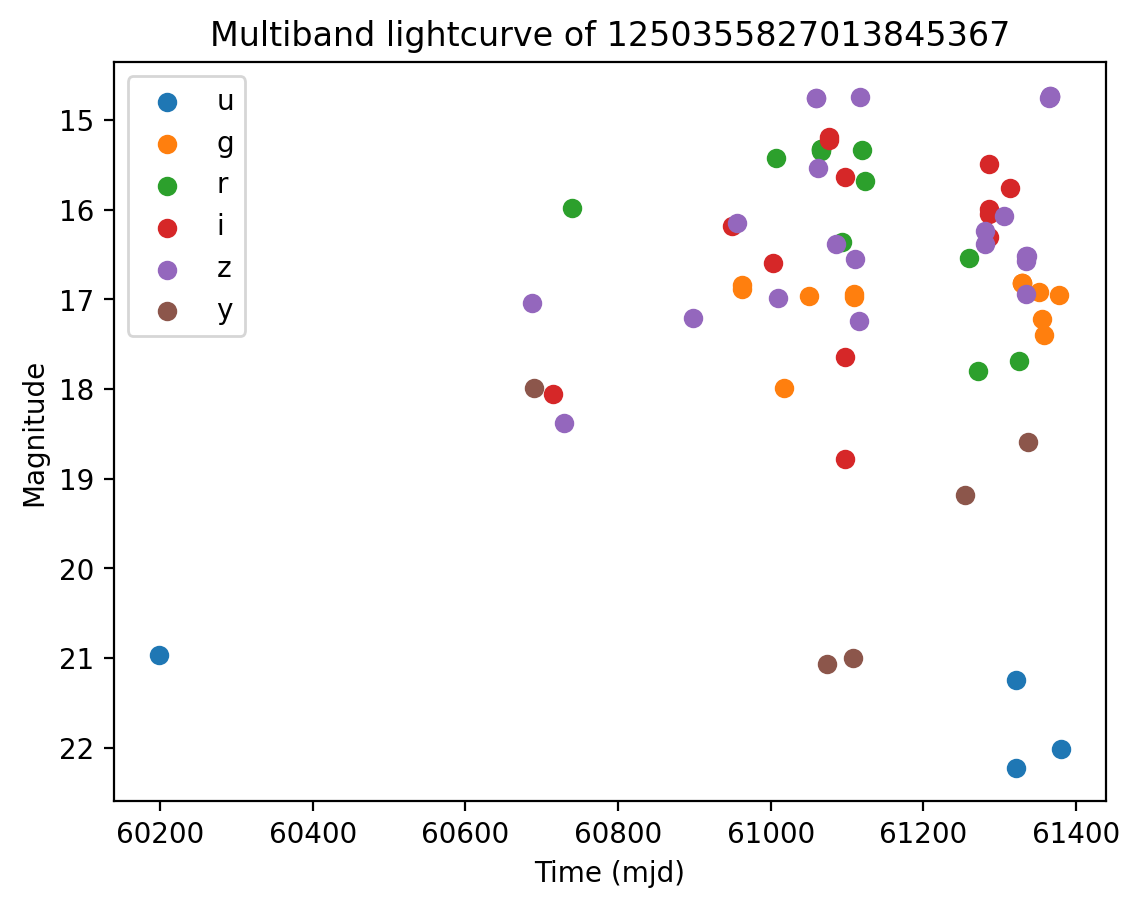

In [26]:
# multiband lightcurve of 
for f in 'ugrizy':
    sub = data[data['filterName'] == f]
    plt.scatter(sub['midPointTai'], sub['psAbMag'], label=f)
plt.legend()
plt.gca().invert_yaxis()
plt.xlabel('Time (mjd)')
plt.ylabel('Magnitude')
plt.title(f'Multiband lightcurve of {objId}')
plt.show()

#### code to find and plot more lightcurves

In [27]:
# # Find 100 objects with >50 detections and an amplitude of at least 1 mag in r band

# test = service.search("SELECT ra, decl, diaObjectId, nDiaSources "
#                       "FROM dp02_dc2_catalogs.DiaObject "
#                       "WHERE nDiaSources > 50 AND "
#                       "scisql_nanojanskyToAbMag(rPSFluxMin)"
#                       f" - scisql_nanojanskyToAbMag(rPSFluxMax) > 1 ",
#                       maxrec=100)

# # Plot many multiband lightcurves
# for obj in test['diaObjectId'].data:
#     results = service.search("SELECT ra, decl, diaObjectId, diaSourceId, "
#                          "filterName, midPointTai, "
#                          "scisql_nanojanskyToAbMag(psFlux) AS psAbMag "
#                          "FROM dp02_dc2_catalogs.DiaSource "
#                          f"WHERE diaObjectId = {obj}").to_table()
#     data = results.to_pandas()
#     plt.figure()
#     for f in 'ugrizy':
#         sub = data[data['filterName'] == f]
#         plt.scatter(sub['midPointTai'], sub['psAbMag'], label=f)
#         plt.legend()
#     plt.gca().invert_yaxis()
#     plt.show()

NameError: name 'ax2' is not defined

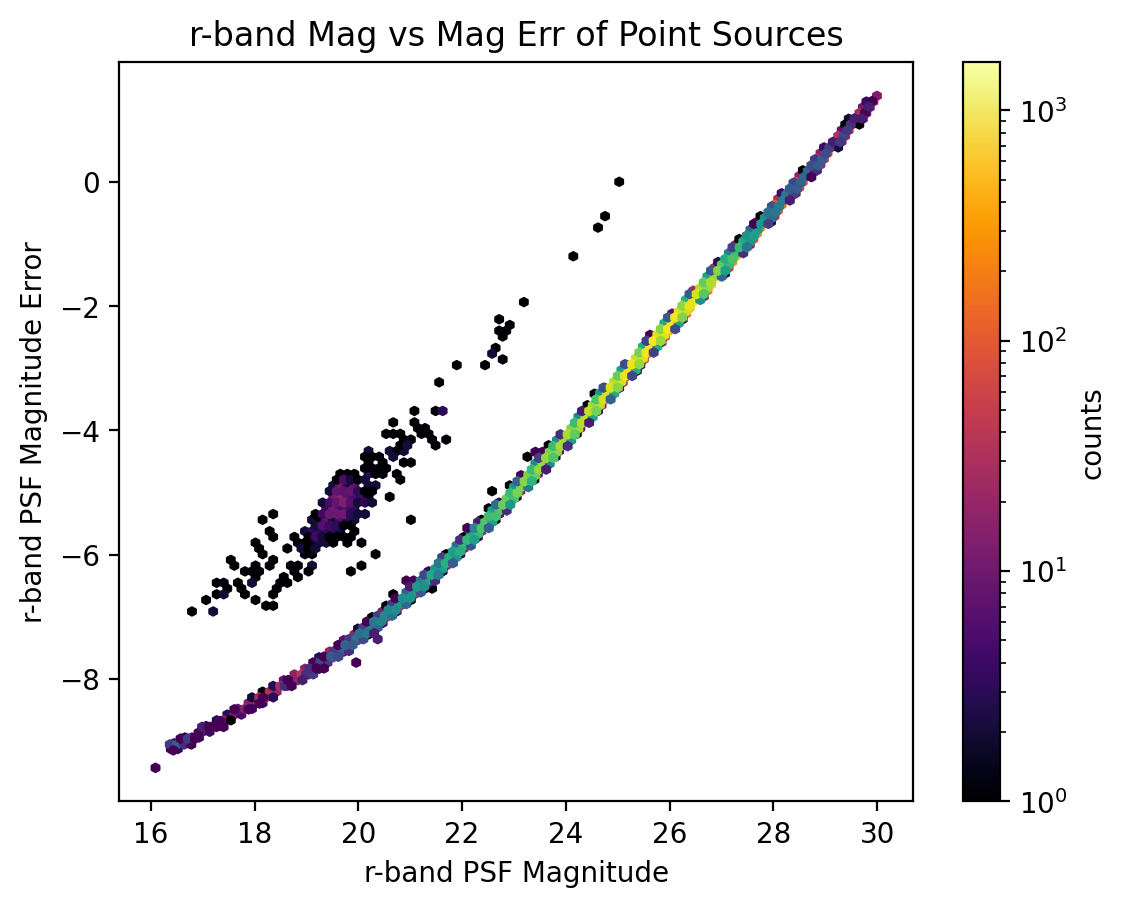

In [28]:
data = df[df['r_psfFlux_flag'] == False ] # Exclude sources with failure flag
data = data.query('r_psfMag < 30') # restrict data to <30 mag, which is already far fainter than the lsst r-band maglim
data_pt = data[data[nonflag].sum(axis=1) == 0] # restrict to pt sources with extendedness == 0 in all 6 bands
data_ext = data[data[nonflag].sum(axis=1) == 6] # restrict to pt sources with extendedness == 1 in all 6 bands

fig, ax = plt.subplots()
hb = ax.hexbin(data_pt['r_psfMag'], np.log(data_pt['r_psfMagErr']), bins='log', cmap='inferno')
ax.set_title("r-band Mag vs Mag Err of Point Sources")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')
ax.set_xlabel('r-band PSF Magnitude')
ax.set_ylabel('r-band PSF Magnitude Error')

# plot 2d histogram with hexbins
hb2 = ax.hexbin(data_ext['r_psfMag'], np.log(data_ext['r_psfMagErr']), bins='log')
ax2.set_title("r-band Mag vs Mag Err of Point Sources")
cb2 = fig.colorbar(hb2, ax=ax)
cb2.set_label('counts')

plt.show()
